# Small box of water as a minimal test system
This is an attempt to isolate and replicate a problem I've been having with my SaltSwap code, namely, the erratic timings that occur between iterations of MD and MC salt insertions and deletions. The MC steps modify the non-bonded parameters of the context.

I only see erratic timings on a GPU and when MD and MC are used together. Not when MD or MC are used seperately. This notebook will try to replicate this behaviour.

In [2]:
import timeit
from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline  

Using a small box of water as a test system:

In [2]:
size = 5.0
wbox = WaterBox(box_edge=size*unit.angstrom, cutoff=size/2*unit.angstrom, nonbondedMethod=app.PME)
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.002*unit.picoseconds)
context = openmm.Context(wbox.system, integrator)
context.setPositions(wbox.positions)
context.setVelocitiesToTemperature(300*unit.kelvin)
integrator.step(100)

Now modifying the non-bonded parameters, updating the parameters in context, and running more MD. 
Updating the parameters of the first water molecule by setting them to zero.

Making sure I've identified the correct forces to modify:

In [3]:
force = wbox.system.getForce(2)       # Non-bonded force.
for i in range(3):
    print force.getParticleParameters(i)

[Quantity(value=-0.834, unit=elementary charge), Quantity(value=0.3150752406575124, unit=nanometer), Quantity(value=0.635968, unit=kilojoule/mole)]
[Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
[Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]


Functions to modify context. These are nonequilibrium switching moves, meant only to test updating the context.

In [9]:
def switchoff(force,context,frac=0.9):
    force.setParticleParameters(0,charge=-0.834*frac,sigma=0.3150752406575124*frac,epsilon=0.635968*frac)
    force.setParticleParameters(1,charge=0.417*frac,sigma=0,epsilon=1*frac)
    force.setParticleParameters(2,charge=0.417*frac,sigma=0,epsilon=1*frac)
    force.updateParametersInContext(context)
    
def switchon(force,context):
    force.setParticleParameters(0,charge=-0.834,sigma=0.3150752406575124,epsilon=0.635968)
    force.setParticleParameters(1,charge=0.417,sigma=0,epsilon=1)
    force.setParticleParameters(2,charge=0.417,sigma=0,epsilon=1)
    force.updateParametersInContext(context)
    
def MDMC(force,context,integrator,steps,i):
    integrator.step(steps)
    if i % 2 == 0:
        switchoff(force,context)
    else:
        switchon(force,context)
        
def MC(force,context,i):
    if i % 2 == 0:
        switchoff(force,context)
    else:
        switchon(force,context)

# Global parameters for MD and MC iterations        
iterations = 200
nsteps = 500

# CPU

## Timing MD on CPU
Using iMac workstation

In [10]:
t_md = []
for i in range(iterations):
    t_md.append(timeit.timeit('integrator.step(nsteps)',setup="from __main__ import context, integrator,nsteps", number=1))    

Percent fluctuation = 8.56


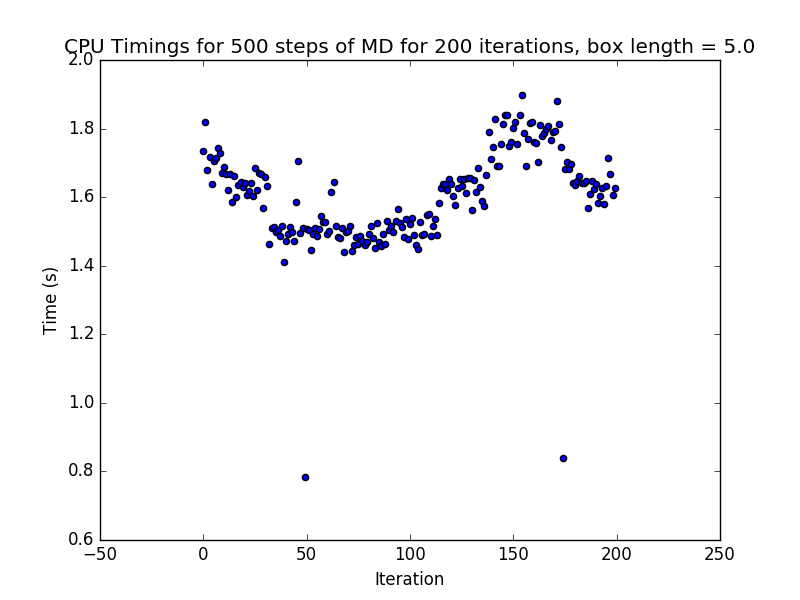

In [24]:
t_md = np.array(t_md)
plt.clf()
plt.scatter(x=np.arange(iterations),y=t_md)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("CPU Timings for {0} steps of MD for {1} iterations, box length = {2}".format(nsteps,iterations,size))
plt.savefig("MD_CPU_{0}{1}{2}.png".format(nsteps,iterations,size))
print "Percent fluctuation = {0:.2f}".format(100*t_md.std()/t_md.mean())
Image("MD_CPU_{0}{1}{2}.png".format(nsteps,iterations,size))

## Timing MC on CPU
Using iMac workstation

In [17]:
t_mc = []
for i in range(iterations):
    t_mc.append(timeit.timeit('MC(force,context,i)',setup="from __main__ import context,force,i, MC", number=1))    

Percent fluctuation = 63.91


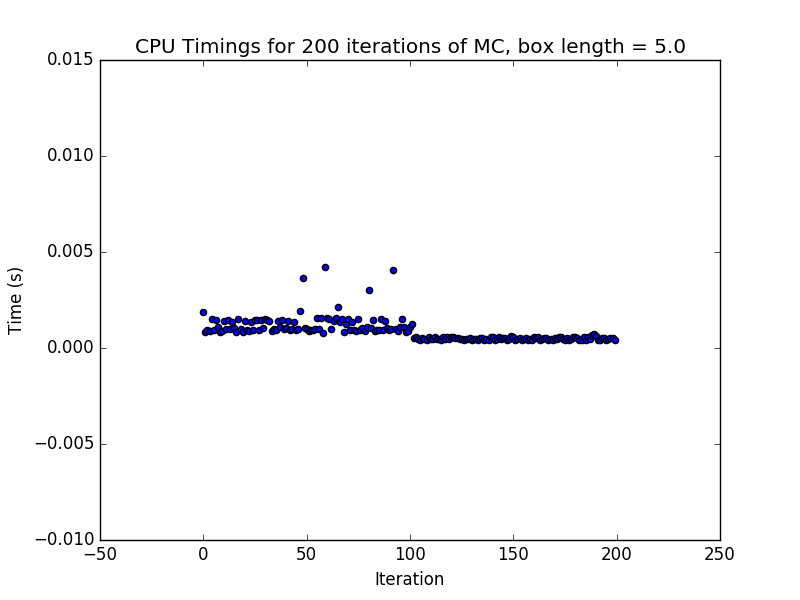

In [25]:
plt.clf()
t_mc = np.array(t_mc)
plt.scatter(x=np.arange(iterations),y=t_mc)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("CPU Timings for {0} iterations of MC, box length = {1}".format(iterations,size))
plt.savefig("MC_CPU_{0}{1}{2}.png".format(nsteps,iterations,size))
print "Percent fluctuation = {0:.2f}".format(100*t_mc.std()/t_mc.mean())
Image("MC_CPU_{0}{1}{2}.png".format(nsteps,iterations,size))

## Timing MD and context manipulation on CPU
Using iMac workstation

In [26]:
t_both = []
for i in range(iterations):
    t_both.append(timeit.timeit('MDMC(force,context,integrator,nsteps,i)',setup="from __main__ import MDMC, force, context, integrator, i,nsteps", number=1))

Percent fluctuation = 3.73


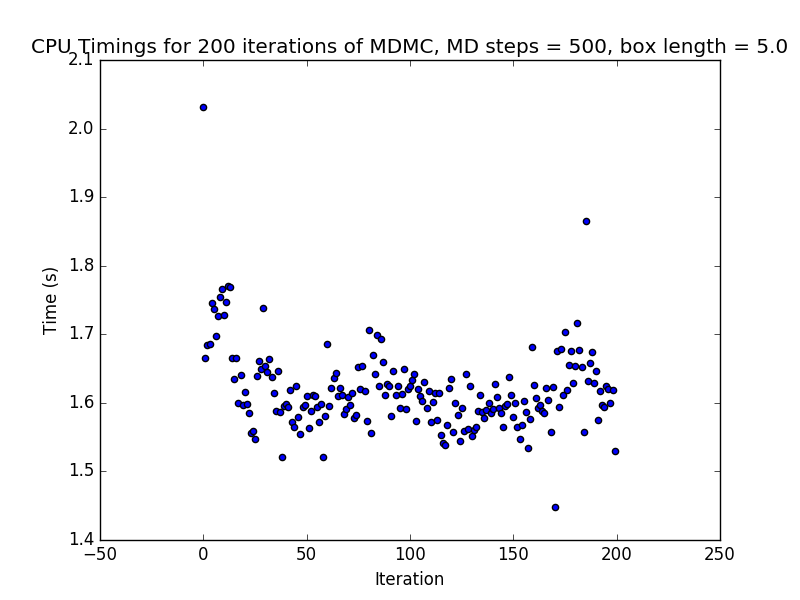

In [28]:
t_both = np.array(t_both)
plt.clf()
plt.scatter(x=np.arange(iterations),y=t_both)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("CPU Timings for {0} iterations of MDMC, MD steps = {1}, box length = {2}".format(iterations,nsteps,size))
plt.savefig("MDMC_CPU_{0}{1}{2}.png".format(nsteps,iterations,size))
print "Percent fluctuation = {0:.2f}".format(100*t_both.std()/t_both.mean())
Image("MDMC_CPU_{0}{1}{2}.png".format(nsteps,iterations,size))


# MDMC combo on GPU
On hal using interactive jobs with the command

  `qsub -I -q active -l walltime=01:00:00 -l nodes=1:ppn=1:gpus=1:shared `

## nsteps = 500, size = 5, iterations = 200

Percent variation = 0.223460


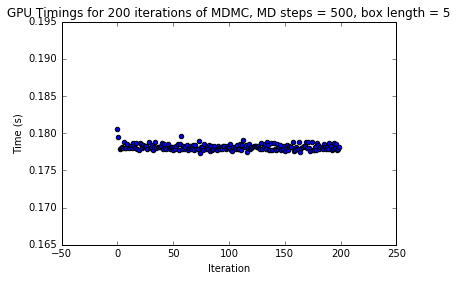

In [4]:
file = open("timings_step500_size5.txt").readlines()
t = []
for line in file[2:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 5")
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))
plt.show()

## nsteps = 500, size = 10, iterations = 200

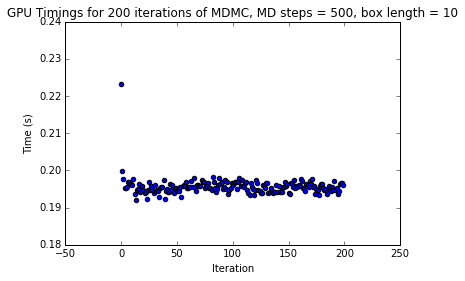

Percent variation = 1.178954


In [5]:
file = open("timings_step500_size10.txt").readlines()
t = []
for line in file[2:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 10")
plt.show()
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))

## nsteps = 5000, size = 10, iterations = 200

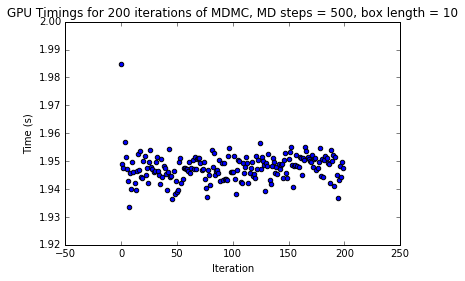

Percent variation = 0.250525


In [6]:
file = open("timings_step5000_size10.txt").readlines()
t = []
for line in file[2:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 10")
plt.show()
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))

## nsteps = 5000, size = 10, iterations = 200, with Langevin compound integrator
The same script was run as before, except the integrator is defined as the compound integrator with Langevin and velocity Verlet. Only the Langevin integrator is used for the timings.

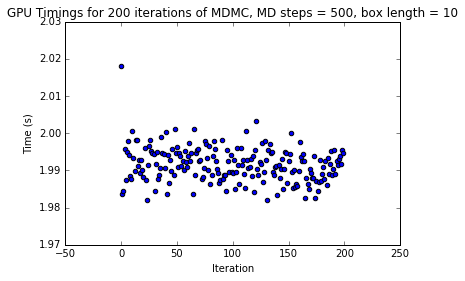

Percent variation = 0.232579


In [4]:
file = open("timings_step5000_size10_CompoundInt.txt").readlines()
t = []
for line in file[2:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 10")
plt.show()
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))

## nsteps = 5000, size = 10, iterations = 200, with velocity Verlet compound integrator
Same as above but with a velocity Verlet integrator. Langevin not used in timings.

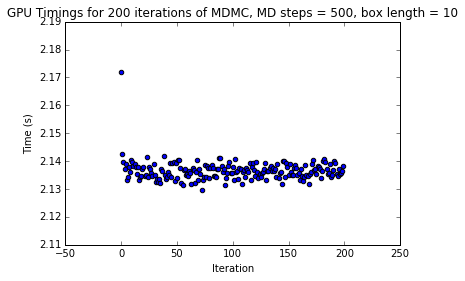

Percent variation = 0.161187


In [3]:
file = open("timings_step5000_size10_vv.txt").readlines()
t = []
for line in file[2:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 10")
plt.show()
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))

# nsteps = 5000, size = 10, iterations = 200, with velocity Verlet AND Langevin compound integrator
Every step the integrator switches between vV and Langevin. 

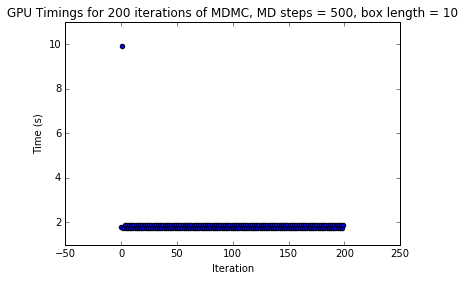

Percent variation = 30.584410


In [7]:
file = open("timings_step5000_size10_LangvV.txt").readlines()
t = []
for line in file[2:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 10")
plt.show()
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))

Interesting that the variation seems so large, as it is mostly dominated by an early data point. I can exclude that point and re-assess:

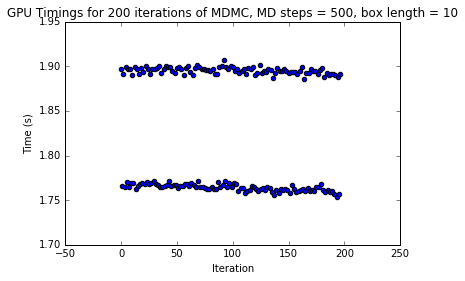

Percent variation = 3.583720


In [8]:
file = open("timings_step5000_size10_LangvV.txt").readlines()
t = []
for line in file[5:]:
    num = float(line.strip("\n"))
    t.append(num)
t = np.array(t)

plt.clf()
plt.scatter(x=np.arange(len(t)),y=t)
plt.xlabel("Iteration")
plt.ylabel("Time (s)")
plt.title("GPU Timings for 200 iterations of MDMC, MD steps = 500, box length = 10")
plt.show()
print "Percent variation = {0:2f}".format(100*np.std(t)/np.mean(t))

This sort of makes sense, as each integrator has a different performance. 